In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array

2022-09-20 00:16:39.123862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 00:16:39.123888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Replace missing values with Zero and Gorup by month

<AxesSubplot:xlabel='date'>

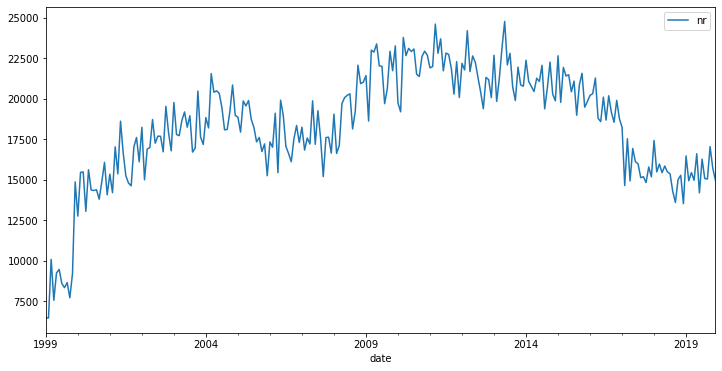

In [2]:
df= pd.read_csv('consumos.csv', parse_dates=['date'])
df['nr'].fillna(value=0, inplace=True)
df=df.groupby('date').sum()
df=df.resample(rule='MS').sum()
dataset = df.values
dataset = df.astype('float32')
df.plot(figsize=(12,6))

### Split Train and Test

In [3]:
train=df[:240] 
test=df[240:]  

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
raw_seq = train['nr'].values.tolist()
n_steps_in, n_steps_out, slide = 6, 6, 2
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out, slide)

In [6]:
X[0], y[0]

(array([ 6469,  6458, 10082,  7551,  9241,  9459]),
 array([ 8589,  8330,  8644,  7706,  9193, 14863]))

### Define and fit MLP model 

In [7]:
# split into samples
# define model
callback = EarlyStopping(monitor='loss', patience=50)
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(n_steps_in,)))
model.add(Dense(500, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0, callbacks=[callback])

2022-09-20 00:16:41.037520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 00:16:41.037578: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 00:16:41.037615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-09-20 00:16:41.037994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Plot losses per epoch

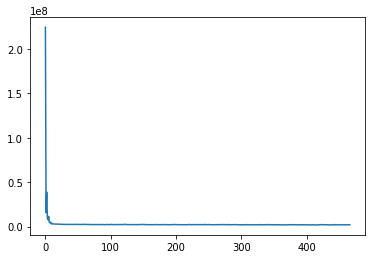

In [8]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Test Predicitions

In [9]:
x_input = array([train['nr'][-n_steps_in:]])
x_input = x_input.reshape((1, n_steps_in))
pred = model.predict(x_input)

In [10]:
x_input = pred
x_input = x_input.reshape((1, n_steps_in))
pred1 = model.predict(x_input)

In [11]:
pred = pred.tolist()[0]
pred1 = pred1.tolist()[0]
pred.extend(pred1)

In [12]:
pred

[15974.216796875,
 14670.4443359375,
 15131.9560546875,
 15612.7099609375,
 16019.8056640625,
 15351.2666015625,
 16496.212890625,
 15247.40625,
 15753.638671875,
 15584.2841796875,
 16013.654296875,
 15406.869140625]

In [13]:
test['nr']

date
2019-01-01    16472
2019-02-01    14936
2019-03-01    15441
2019-04-01    14967
2019-05-01    16606
2019-06-01    14191
2019-07-01    16275
2019-08-01    15074
2019-09-01    15047
2019-10-01    17045
2019-11-01    15719
2019-12-01    14969
Freq: MS, Name: nr, dtype: int64

### Calculate Error

In [14]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [15]:
np.sqrt(mean_squared_error(test['nr'], pred)), mean_absolute_error(test['nr'], pred), MAPE(array([test['nr']]), pred)

(677.6911881405789, 563.2542317708334, 3.6164130560989216)

### Plot

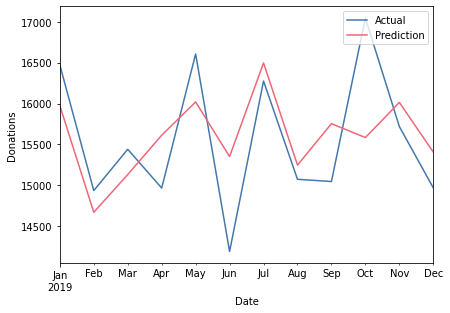

In [16]:
cm = 1/2.54 
test['nr'].plot(legend=True, color=['#4477AA'])
pd.DataFrame(pred, index=test.index.values, columns=['nr'])['nr'].plot(figsize=(17*cm,12*cm), color=['#EE6677'])
plt.legend(['Actual', 'Prediction'],loc='upper right')
plt.ylabel('Donations')
plt.xlabel('Date')
plt.savefig('MLP.pdf')

In [17]:
index_of_fc = pd.date_range(df[240:].index[0], periods = 12, freq='MS')
# make series for plotting purpose
demand_prediction_mlp = pd.Series(array(pred), index=index_of_fc)
%store demand_prediction_mlp

Stored 'demand_prediction_mlp' (Series)
